# 01 - Data Preparation

> Scaffold notebook — fill with data and code.

## Setup

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import json

# yeni path
DATA_DIR = Path("../data/open-data/data/events")

# alt klasörlerdeki tüm json dosyalarını bulalım
event_files = list(DATA_DIR.rglob("*.json"))
# print(f"Total event files found: {len(event_files)}")
events = []
for f in event_files:
    with open(f, "r", encoding="utf-8") as file:
        events.extend(json.load(file))

print(f"Total event files found: {len(events)}")


Total event files found: 12188949


## Load data

In [6]:
all_events = events
sample_file = event_files[0]

with open(sample_file, "r", encoding="utf-8") as f:
    sample_events = json.load(f)

print(len(sample_events))


3762


## Clean & normalize

In [8]:
from pathlib import Path
import json
import pandas as pd
from tqdm import tqdm

event_files = list(Path("../data/open-data/data/events").rglob("*.json"))

output_path = Path("../data/processed/shots.csv")

# Çıktı kolonları
cols = [
    "team_name",
    "player_name",
    "location",
    "shot_body_part_name",
    "shot_outcome_name",
    "under_pressure"
]

first_write = True

for f in tqdm(event_files, desc="Extracting minimal shot data"):
    with open(f, "r", encoding="utf-8") as file:
        events = json.load(file)

        shot_events = [
            ev for ev in events
            if ev.get("type", {}).get("name") == "Shot"
        ]

        if not shot_events:
            continue

        # Normalize
        df_batch = pd.json_normalize(shot_events, sep="_")

        # Sadece gereken kolonları oluştur
        df_out = pd.DataFrame()
        df_out["team_name"] = df_batch.get("team_name")
        df_out["player_name"] = df_batch.get("player_name")
        df_out["location"] = df_batch.get("location")
        df_out["shot_body_part_name"] = df_batch.get("shot_body_part_name")
        df_out["shot_outcome_name"] = df_batch.get("shot_outcome_name")
        df_out["under_pressure"] = df_batch.get("under_pressure")

        df_out.to_csv(
            output_path,
            mode="a",
            header=first_write,
            index=False
        )

        first_write = False

print("DONE → Saved minimal shots:", output_path)



Extracting minimal shot data: 100%|██████████| 3464/3464 [02:59<00:00, 19.27it/s]

DONE → Saved minimal shots: ..\data\processed\shots.csv


In [9]:
df = pd.read_csv("../data/processed/shots.csv")

df["x"] = df["location"].apply(lambda v: eval(v)[0])
df["y"] = df["location"].apply(lambda v: eval(v)[1])

df.to_csv("../data/processed/shots.csv", index=False)


## Quick visualization

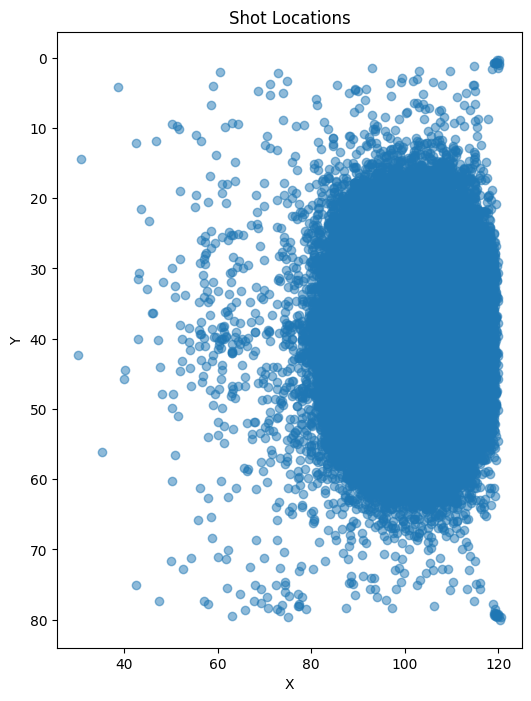

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 8))
plt.scatter(df["x"], df["y"], alpha=0.5)
plt.gca().invert_yaxis()
plt.title("Shot Locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


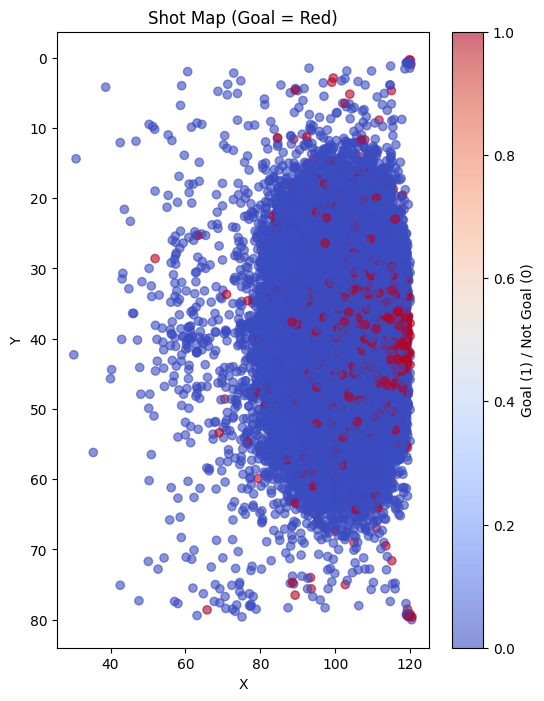

In [12]:
df["is_goal"] = (df["shot_outcome_name"] == "Goal").astype(int)

plt.figure(figsize=(6, 8))
plt.scatter(df["x"], df["y"], c=df["is_goal"], cmap="coolwarm", alpha=0.6)
plt.gca().invert_yaxis()
plt.title("Shot Map (Goal = Red)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Goal (1) / Not Goal (0)")
plt.show()
